In [1]:
import numpy as np
from collections import OrderedDict
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from functools import reduce
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
%config InlineBackend.figure_format = 'retina'
train_on_gpu = torch.cuda.is_available()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Inputs**: 
- `path_to_train`: Path to your training set folder (I am using PyTorch's `ImageFolder` module)
- `path_to_test`: Path to your test set folder
- `num_workers`: number of subprocesses to use for data loading
- `batch_size`: how many samples per batch to load
- `valid_size`: percentage of training set to use as validation



In [2]:

def DataConstructor2000(path_to_train, path_to_test, classes=None, num_workers=4, batch_size=32, valid_size = 0.2):
    
  
    # Transformations to the image, edit as need be
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize([32,32]),
        transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(path_to_train, transform=transform)
    print("Successfully Loaded Training Set.")

    test_dataset = datasets.ImageFolder(path_to_test, transform=transform)
    print("Successfully Loaded Test Set.")

    
    # obtain training indices that will be used for validation
    num_train = len(train_dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, 
        num_workers=num_workers, shuffle=True)
    if classes != None:
        print("Number of Classes:", len(classes))
    return train_loader, valid_loader, test_loader, classes

In [3]:
train_loader, valid_loader,test_loader, classes = DataConstructor2000(path_to_train='/content/drive/MyDrive/EC523DATA/train/airplane',path_to_test='/content/drive/MyDrive/EC523DATA/testairplane/airplane',classes=['Real','Fake'],num_workers=2, batch_size=130, valid_size = 0.3)

Successfully Loaded Training Set.
Successfully Loaded Test Set.
Number of Classes: 2


## Confirmation


(120, 3, 32, 32)


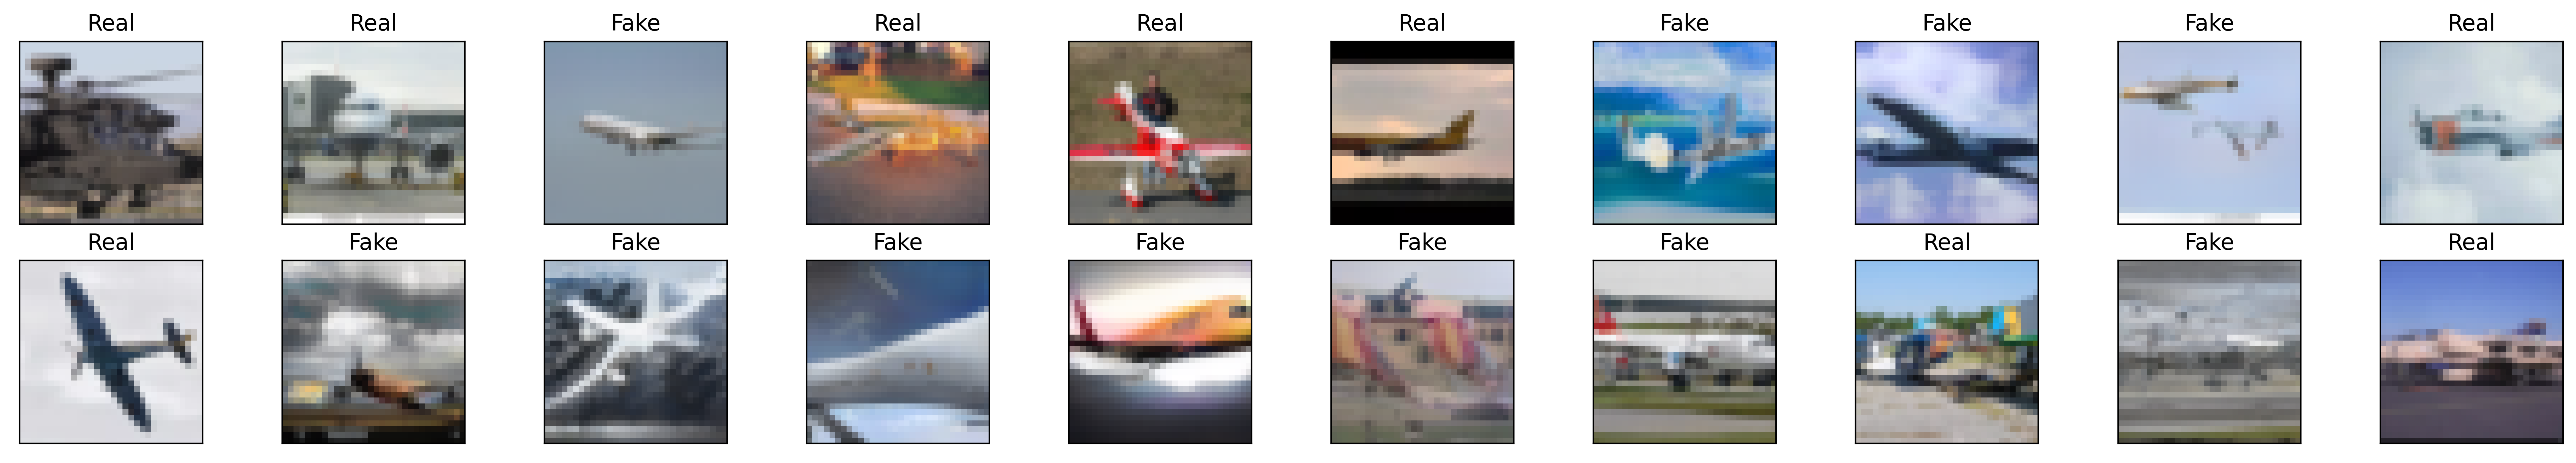

In [12]:
# helper function to un-normalize and display an image
def imshow(img):
#     img = img / 2 + 0.5  # unnormalize if you added normalization in the transformation step
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])



## Model


In [4]:
class Bottleneck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(Bottleneck, self).__init__()
        interChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)
        return out

class SingleLayer(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = torch.cat((x, out), 1)
        return out

class Transition(nn.Module):
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, growthRate, depth, reduction, nClasses, bottleneck):
        super(DenseNet, self).__init__()

        nDenseBlocks = (depth-4) // 3
        if bottleneck:
            nDenseBlocks //= 2

        nChannels = 2*growthRate
        self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1,
                               bias=False)
        self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans1 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans2 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate

        self.bn1 = nn.BatchNorm2d(nChannels)
        self.fc = nn.Linear(nChannels, nClasses)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_dense(self, nChannels, growthRate, nDenseBlocks, bottleneck):
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(Bottleneck(nChannels, growthRate))
            else:
                layers.append(SingleLayer(nChannels, growthRate))
            nChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = torch.squeeze(F.avg_pool2d(F.relu(self.bn1(out)), 8))
        out = F.log_softmax(self.fc(out))
        return out



In [5]:
model = DenseNet(growthRate=12, depth=100, reduction=0.5,
bottleneck=True, nClasses=2).cuda()
model = nn.DataParallel(model)

## Loss Function and Optimizer

In [6]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optimizer = torch.optim.SGD([
    {'params': list(model.parameters())[:-1], 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-3},
    {'params': list(model.parameters())[-1], 'lr': 5e-5, 'momentum': 0.9, 'weight_decay': 1e-5}
])

## Train

In [7]:
import torch
torch.cuda.empty_cache()

In [8]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
training_vis = []
valid_vis = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    torch.cuda.empty_cache()    
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    training_vis.append(train_loss)
    valid_vis.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\nValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'DenseNet35656_gan-detector_Final.pt')
        valid_loss_min = valid_loss

    torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 0.486527 	Validation Loss: 0.207978

Validation loss decreased (inf --> 0.207978).  Saving model ...
Epoch: 2 	Training Loss: 0.484252 	Validation Loss: 0.207370

Validation loss decreased (0.207978 --> 0.207370).  Saving model ...
Epoch: 3 	Training Loss: 0.483491 	Validation Loss: 0.207645
Epoch: 4 	Training Loss: 0.482869 	Validation Loss: 0.207061

Validation loss decreased (0.207370 --> 0.207061).  Saving model ...
Epoch: 5 	Training Loss: 0.481778 	Validation Loss: 0.206814

Validation loss decreased (0.207061 --> 0.206814).  Saving model ...
Epoch: 6 	Training Loss: 0.481218 	Validation Loss: 0.206821
Epoch: 7 	Training Loss: 0.480189 	Validation Loss: 0.207018
Epoch: 8 	Training Loss: 0.479551 	Validation Loss: 0.206080

Validation loss decreased (0.206814 --> 0.206080).  Saving model ...
Epoch: 9 	Training Loss: 0.478130 	Validation Loss: 0.206123
Epoch: 10 	Training Loss: 0.477208 	Validation Loss: 0.205374

Validation loss decreased (0.206080 --> 0.2

## Load Model

In [ ]:
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load('./DenseNet35656_gan-detector_after72.pt'))


NameError: ignored

## Test

In [9]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
#     print(target)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
#     print(output)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
#     print(pred)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(2):
#         print(i)
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 1.054959

Test Accuracy of  Real: 94% (16/17)
Test Accuracy of  Fake: 47% (11/23)

Test Accuracy (Overall): 67% (27/40)


## Visualize Model Performance


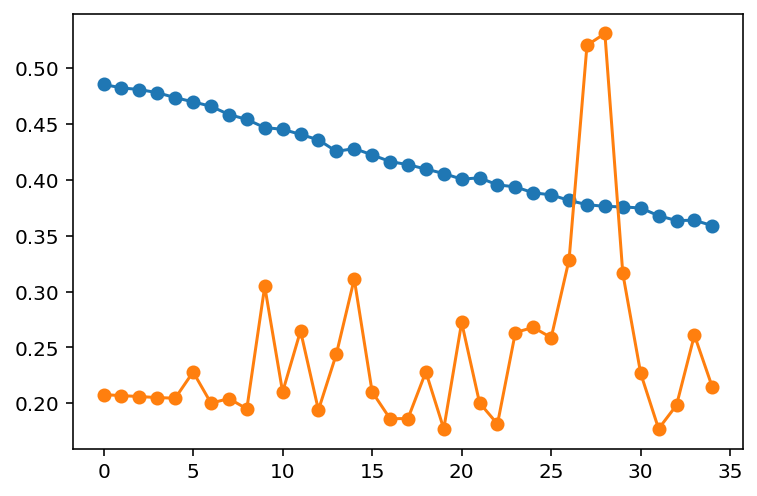

In [ ]:
plt.plot(range(epoch), training_vis)
plt.scatter(range(epoch), training_vis)
plt.scatter(range(epoch), valid_vis)
plt.plot(range(epoch), valid_vis)
# np.savetxt('DenseNet.txt', [training_vis, valid_vis])
# plt.savefig()

## Visualize Misclassified



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(20, 3, 32, 32)


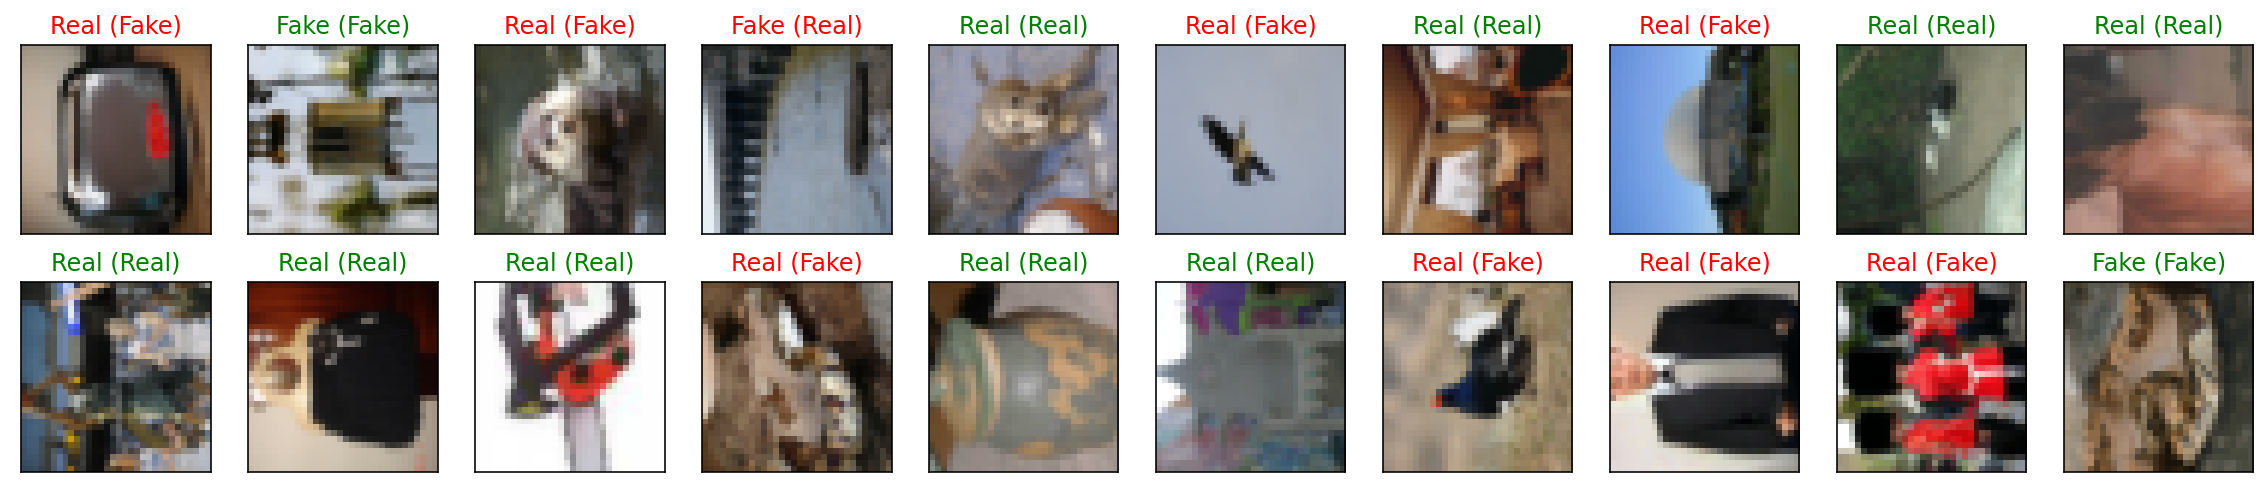

In [ ]:
# # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
labels = labels.numpy()
print(images.shape)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.swapaxes((images[idx]),axis1=0, axis2=2))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if classes[preds[idx]]==classes[labels[idx]] else "red"))
plt.savefig('Densenet_misclass.pdf')

## Bonus Sanity Check Visualization


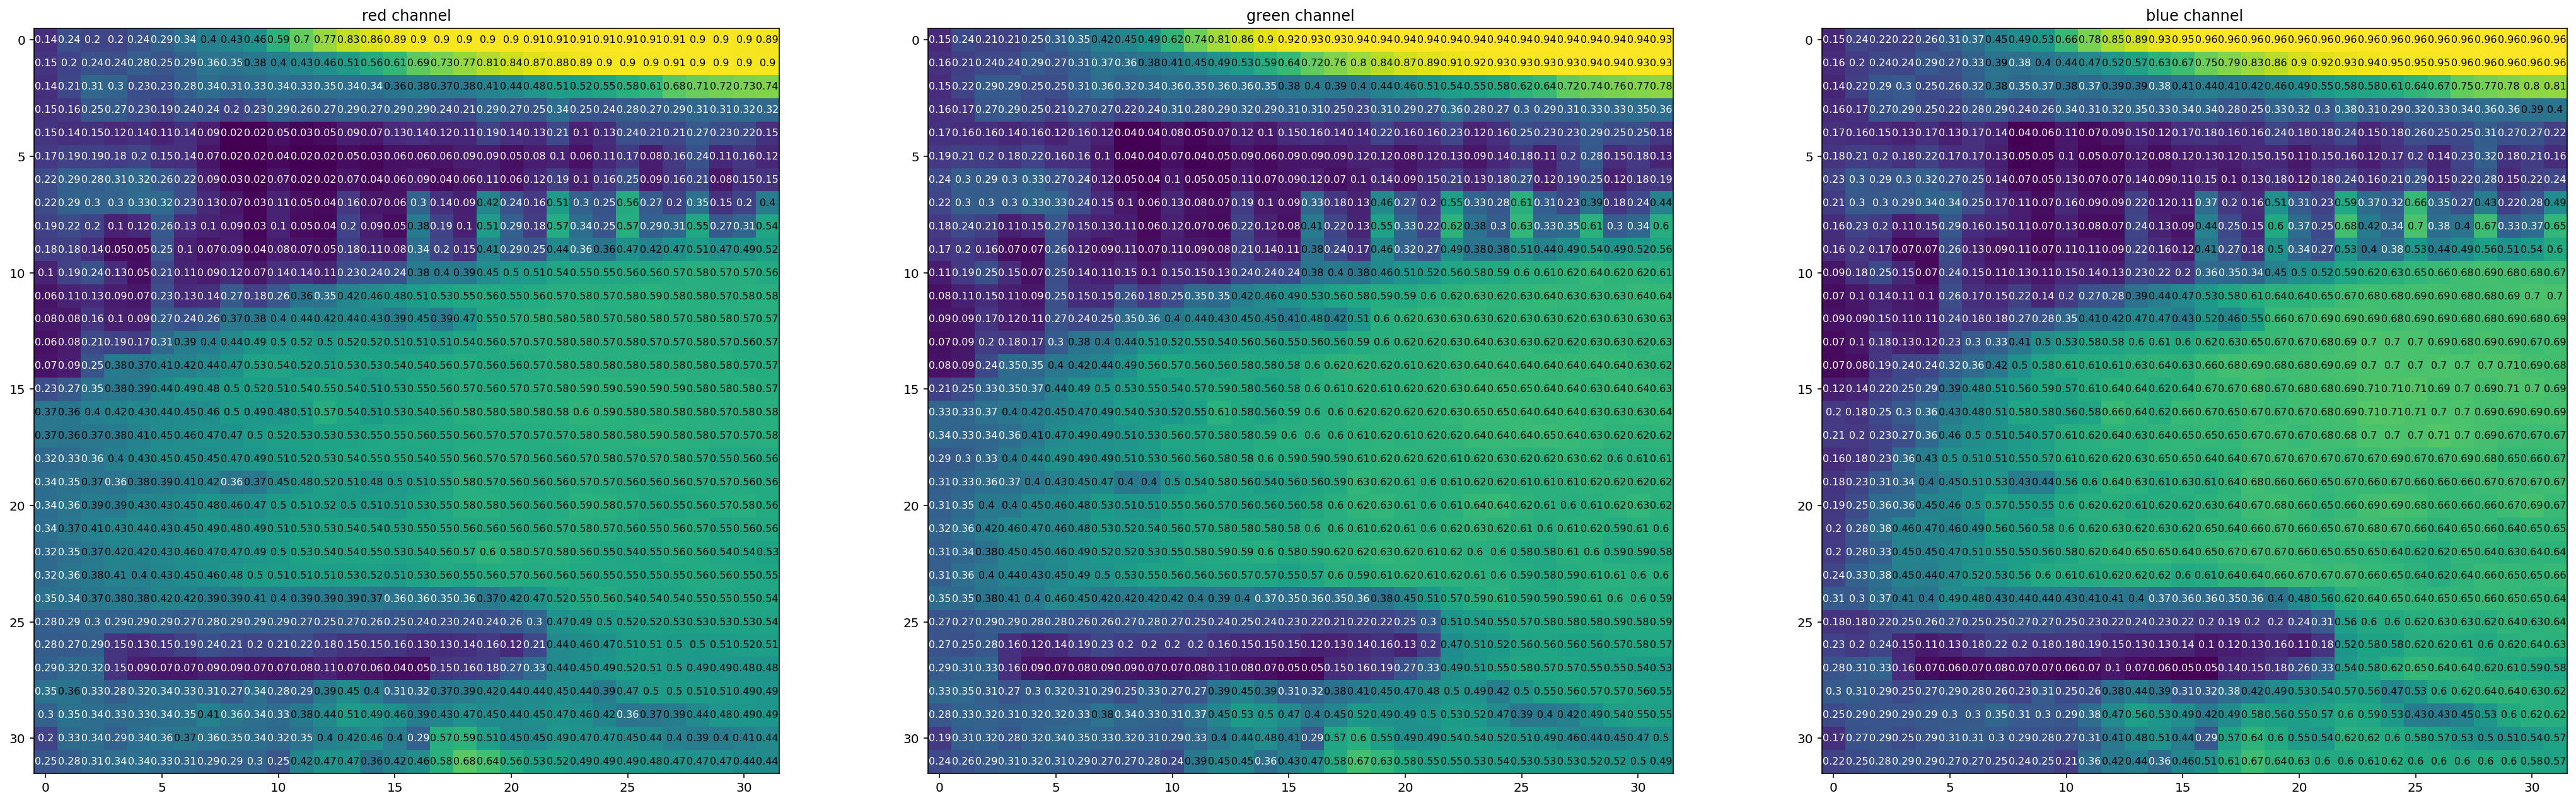

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img)
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

***